<a href="https://colab.research.google.com/github/VatsalSin/PyData-Patna/blob/main/PyData_Patna_LSTM_and_N_BEATS_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#dowload the dataset
!wget https://raw.githubusercontent.com/VatsalSin/PyData-Patna/main/Datasets/%5EDJI.csv

--2020-12-05 00:26:29--  https://raw.githubusercontent.com/VatsalSin/PyData-Patna/main/Datasets/%5EDJI.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 422460 (413K) [text/plain]
Saving to: ‘^DJI.csv’

^DJI.csv            100%[===================>] 412.56K  --.-KB/s    in 0.007s  

2020-12-05 00:26:29 (61.1 MB/s) - ‘^DJI.csv’ saved [422460/422460]



In [2]:
import numpy as np
from keras.models import Sequential
from keras.layers.convolutional import Conv2D 
from keras.utils import np_utils
from keras import backend as K
from keras import backend as K
from keras.layers import Concatenate
from keras.layers import Input, Dense, Lambda, Subtract, Add, Reshape
from keras.models import Model
from keras.optimizers import Adam


class NBeatsNet:
    GENERIC_BLOCK = 'generic'
    TREND_BLOCK = 'trend'
    SEASONALITY_BLOCK = 'seasonality'

    def __init__(self,
                 input_dim=1,
                 exo_dim=0,
                 backcast_length=10,
                 forecast_length=2,
                 stack_types=(TREND_BLOCK, SEASONALITY_BLOCK),
                 nb_blocks_per_stack=3,
                 thetas_dim=(4, 8),
                 share_weights_in_stack=False,
                 hidden_layer_units=256,
                 nb_harmonics=None
                 ):

        self.stack_types = stack_types
        self.nb_blocks_per_stack = nb_blocks_per_stack
        self.thetas_dim = thetas_dim
        self.units = hidden_layer_units
        self.share_weights_in_stack = share_weights_in_stack
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length
        self.input_dim = input_dim
        self.exo_dim = exo_dim
        self.input_shape = (self.backcast_length, self.input_dim)
        self.exo_shape = (self.backcast_length, self.exo_dim)
        self.output_shape = (self.forecast_length, self.input_dim)
        self.weights = {}
        self.nb_harmonics = nb_harmonics
        assert len(self.stack_types) == len(self.thetas_dim)

        x = Input(shape=self.input_shape, name='input_variable')
        x_ = {}
        for k in range(self.input_dim):
            x_[k] = Lambda(lambda z: z[..., k])(x)
        e_ = {}
        if self.has_exog():
            e = Input(shape=self.exo_shape, name='exos_variables')
            for k in range(self.exo_dim):
                e_[k] = Lambda(lambda z: z[..., k])(e)
        else:
            e = None
        y_ = {}

        for stack_id in range(len(self.stack_types)):
            stack_type = self.stack_types[stack_id]
            nb_poly = self.thetas_dim[stack_id]
            for block_id in range(self.nb_blocks_per_stack):
                backcast, forecast = self.create_block(x_, e_, stack_id, block_id, stack_type, nb_poly)
                for k in range(self.input_dim):
                    x_[k] = Subtract()([x_[k], backcast[k]])
                    if stack_id == 0 and block_id == 0:
                        y_[k] = forecast[k]
                    else:
                        y_[k] = Add()([y_[k], forecast[k]])

        for k in range(self.input_dim):
            y_[k] = Reshape(target_shape=(self.forecast_length, 1))(y_[k])
        if self.input_dim > 1:
            y_ = Concatenate(axis=-1)([y_[ll] for ll in range(self.input_dim)])
        else:
            y_ = y_[0]

        if self.has_exog():
            model = Model([x, e], y_)
        else:
            model = Model(x, y_)

        model.summary()

        self.n_beats = model

    def has_exog(self):
        return self.exo_dim > 0

    @staticmethod
    def load(filepath, custom_objects=None, compile=True):
        from tensorflow.keras.models import load_model
        return load_model(filepath, custom_objects, compile)

    def _r(self, layer_with_weights, stack_id):
        # mechanism to restore weights when block share the same weights.
        # only useful when share_weights_in_stack=True.
        if self.share_weights_in_stack:
            layer_name = layer_with_weights.name.split('/')[-1]
            try:
                reused_weights = self.weights[stack_id][layer_name]
                return reused_weights
            except KeyError:
                pass
            if stack_id not in self.weights:
                self.weights[stack_id] = {}
            self.weights[stack_id][layer_name] = layer_with_weights
        return layer_with_weights

    def create_block(self, x, e, stack_id, block_id, stack_type, nb_poly):

        # register weights (useful when share_weights_in_stack=True)
        def reg(layer):
            return self._r(layer, stack_id)

        # update name (useful when share_weights_in_stack=True)
        def n(layer_name):
            return '/'.join([str(stack_id), str(block_id), stack_type, layer_name])

        backcast_ = {}
        forecast_ = {}
        d1 = reg(Dense(self.units, activation='relu', name=n('d1')))
        d2 = reg(Dense(self.units, activation='relu', name=n('d2')))
        d3 = reg(Dense(self.units, activation='relu', name=n('d3')))
        d4 = reg(Dense(self.units, activation='relu', name=n('d4')))
        if stack_type == 'generic':
            theta_b = reg(Dense(nb_poly, activation='linear', use_bias=False, name=n('theta_b')))
            theta_f = reg(Dense(nb_poly, activation='linear', use_bias=False, name=n('theta_f')))
            backcast = reg(Dense(self.backcast_length, activation='linear', name=n('backcast')))
            forecast = reg(Dense(self.forecast_length, activation='linear', name=n('forecast')))
        elif stack_type == 'trend':
            theta_f = theta_b = reg(Dense(nb_poly, activation='linear', use_bias=False, name=n('theta_f_b')))
            backcast = Lambda(trend_model, arguments={"is_forecast": False, "backcast_length": self.backcast_length,
                                                      "forecast_length": self.forecast_length})
            forecast = Lambda(trend_model, arguments={"is_forecast": True, "backcast_length": self.backcast_length,
                                                      "forecast_length": self.forecast_length})
        else:  # 'seasonality'
            if self.nb_harmonics:
                theta_b = reg(Dense(self.nb_harmonics, activation='linear', use_bias=False, name=n('theta_b')))
            else:
                theta_b = reg(Dense(self.forecast_length, activation='linear', use_bias=False, name=n('theta_b')))
            theta_f = reg(Dense(self.forecast_length, activation='linear', use_bias=False, name=n('theta_f')))
            backcast = Lambda(seasonality_model,
                              arguments={"is_forecast": False, "backcast_length": self.backcast_length,
                                         "forecast_length": self.forecast_length})
            forecast = Lambda(seasonality_model,
                              arguments={"is_forecast": True, "backcast_length": self.backcast_length,
                                         "forecast_length": self.forecast_length})
        for k in range(self.input_dim):
            if self.has_exog():
                d0 = Concatenate()([x[k]] + [e[ll] for ll in range(self.exo_dim)])
            else:
                d0 = x[k]
            d1_ = d1(d0)
            d2_ = d2(d1_)
            d3_ = d3(d2_)
            d4_ = d4(d3_)
            theta_f_ = theta_f(d4_)
            theta_b_ = theta_b(d4_)
            backcast_[k] = backcast(theta_b_)
            forecast_[k] = forecast(theta_f_)

        return backcast_, forecast_

    def compile_model(self, loss, learning_rate, metrics):
        optimizer = Adam(lr=learning_rate)
        self.compile(loss=loss, optimizer=optimizer, metrics =['mse','mape','mae'])

    def __getattr__(self, name):
        # https://github.com/faif/python-patterns
        # model.predict() instead of model.n_beats.predict()
        # same for fit(), train_on_batch()...
        attr = getattr(self.n_beats, name)

        if not callable(attr):
            return attr

        def wrapper(*args, **kwargs):
            return attr(*args, **kwargs)

        return wrapper


def linear_space(backcast_length, forecast_length, fwd_looking=True):
    ls = K.arange(-float(backcast_length), float(forecast_length), 1) / backcast_length
    if fwd_looking:
        ls = ls[backcast_length:]
    else:
        ls = ls[:backcast_length]
    return ls


def seasonality_model(thetas, backcast_length, forecast_length, is_forecast):
    p = thetas.get_shape().as_list()[-1]
    p1, p2 = (p // 2, p // 2) if p % 2 == 0 else (p // 2, p // 2 + 1)
    t = linear_space(backcast_length, forecast_length, fwd_looking=is_forecast)
    s1 = K.stack([K.cos(2 * np.pi * i * t) for i in range(p1)], axis=0)
    s2 = K.stack([K.sin(2 * np.pi * i * t) for i in range(p2)], axis=0)
    if p == 1:
        s = s2
    else:
        s = K.concatenate([s1, s2], axis=0)
    s = K.cast(s, np.float32)
    return K.dot(thetas, s)


def trend_model(thetas, backcast_length, forecast_length, is_forecast):
    p = thetas.shape[-1]
    t = linear_space(backcast_length, forecast_length, fwd_looking=is_forecast)
    t = K.transpose(K.stack([t ** i for i in range(p)], axis=0))
    t = K.cast(t, np.float32)
    return K.dot(thetas, K.transpose(t))

In [3]:
#importing the important libraries

import numpy as np
import pandas as pd
import pywt
import copy
import warnings
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense,LSTM,Dropout,Input,BatchNormalization,Conv1D, MaxPooling1D, Flatten
from keras.models import Model
from keras import Sequential


In [5]:
#imporing the dataset
df = pd.read_csv("/content/^DJI.csv")
dates = df['Date']
df = df.drop(['Date'], axis = 1)

In [6]:
#printing the dataset
df

,Open,High,Low,Close,Adj Close,Volume
0,11501.849609,11522.009766,11305.690430,11357.509766,11357.509766,169750000
1,11349.750000,11350.059570,10986.450195,10997.929688,10997.929688,178420000
2,10989.370117,11215.099609,10938.669922,11122.650391,11122.650391,203190000
3,11113.370117,11313.450195,11098.450195,11253.259766,11253.259766,176550000
4,11247.059570,11528.139648,11239.919922,11522.559570,11522.559570,184900000
...,...,...,...,...,...,...
4962,27034.070313,27079.679688,26704.960938,26807.769531,26807.769531,301750000
4963,26866.710938,27016.560547,26755.859375,26970.710938,26970.710938,237220000
4964,27004.109375,27015.070313,26803.839844,26891.119141,26891.119141,229180000
4965,26987.259766,27012.539063,26715.820313,26820.250000,26820.250000,217780000


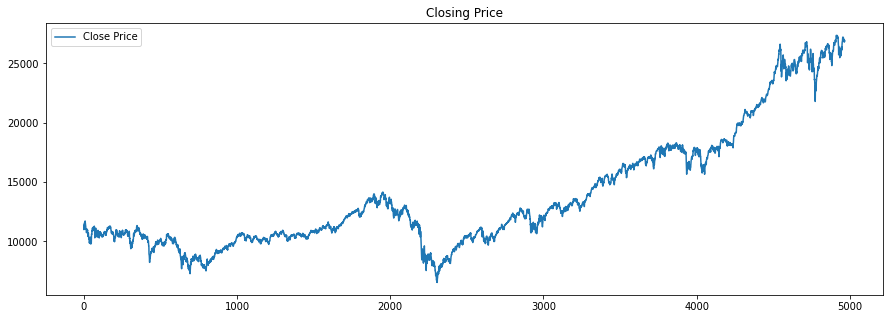

In [7]:
#plotting the dataset
plt.figure(figsize=(15, 5))
plt.plot(df['Close'], label = 'Close Price')
plt.title('Closing Price')
plt.legend()
plt.show()

In [8]:
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df['Close'].values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df['Close'].values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df['Close'].values.reshape(-1,1))
    df['Close'] = min_max_scaler.fit_transform(df['Close'].values.reshape(-1,1))
    return df

def load_data(stock, feature, dates, seq_len, valid_set_size_percentage, test_set_size_percentage):
    stock = stock[feature]
    data_raw = stock.values
    dates = dates.values
    data = []
    dates_record = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
        dates_record.append(dates[index + seq_len-1])

    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]))
    train_set_size = data.shape[0] - (valid_set_size + test_set_size)
    print (valid_set_size,test_set_size)
    print (data.shape[0])
    
    x_train = data[:train_set_size,:-1]
    y_train = data[:train_set_size,-1]
    y_train_dates = dates_record[:train_set_size]

    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1]
    y_valid_dates = dates_record[train_set_size:train_set_size+valid_set_size]
    

    x_test = data[train_set_size+valid_set_size:,:-1]
    y_test = data[train_set_size+valid_set_size:,-1]
    y_test_dates = dates_record[train_set_size+valid_set_size:]
    
    return [x_train, y_train, y_train_dates, x_valid, y_valid, y_valid_dates, x_test, y_test, y_test_dates]


In [9]:
#normalise the dataset using min-max scaler
df_norm = normalize_data(df.copy())

### LSTM Model

In [10]:
#splitting the data in train, test and validation set after creating windows
seq_len = 20  
x_train, y_train, y_train_dates, x_valid, y_valid, y_valid_dates, x_test, y_test, y_test_dates = load_data(df_norm, ['Open', 'High', 'Low', 'Close'], dates, seq_len, 5, 5)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

247 247
4947
x_train.shape =  (4453, 19, 4)
y_train.shape =  (4453, 4)
x_valid.shape =  (247, 19, 4)
y_valid.shape =  (247, 4)
x_test.shape =  (247, 19, 4)
y_test.shape =  (247, 4)


In [11]:
#building and traing the lstm model
time_steps, input_dim, output_dim = 19, 4, 4
model = Sequential()
model.add(Input((time_steps,input_dim)))
model.add(LSTM(200, return_sequences=True))
model.add(LSTM(200))
model.add(Dense(output_dim,activation='relu'))

model.compile(loss = 'mean_squared_error',optimizer=keras.optimizers.Adam(),metrics =['mse','mape','mae'])
model.summary()
model.fit(x=x_train,y=y_train, batch_size=10, epochs = 100,validation_data=(x_valid,y_valid), shuffle=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 19, 200)           164000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense (Dense)                (None, 4)                 804       
Total params: 485,604
Trainable params: 485,604
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
446/446 [==============================] - 3s 8ms/step - loss: 0.0016 - mse: 0.0016 - mape: 4487.8457 - mae: 0.0157 - val_loss: 5.5458e-04 - val_mse: 5.5458e-04 - val_mape: 1.9369 - val_mae: 0.0168
Epoch 2/100
446/446 [==============================] - 3s 6ms/step - loss: 1.5125e-04 - mse: 1.5125e-04 - mape: 3993.2935 - mae: 0.0093 - val_loss: 8.4629e-04 - val_mse: 

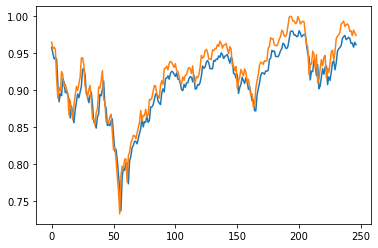

RSME = 0.01718616529894593
MSE = 0.00029536427768269325
MAE = 0.015156257079771873


In [12]:
#forecasting using the trained model
y_pred =model.predict(x_test)
y_pred_close = y_pred[:,-1]
y_test_close = y_test[:,-1]
plt.plot(y_pred_close)
plt.plot(y_test_close)
plt.show()
MAE = np.mean(np.abs(y_test_close - y_pred_close))
RMSE = np.sqrt(np.mean(np.square(y_test_close - y_pred_close)))
MSE = np.mean(np.square(y_test_close - y_pred_close))
print("RSME = " + str(RMSE))
print("MSE = " + str(MSE))
print("MAE = " + str(MAE))

In [13]:
#rescaling the values
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(df['Close'].values.reshape(-1,1))
data_min = scaler.data_min_[0]
data_range = scaler.data_range_[0]
y_pred_close = (y_pred_close*data_range)+data_min
y_test_close = (y_test_close*data_range)+data_min

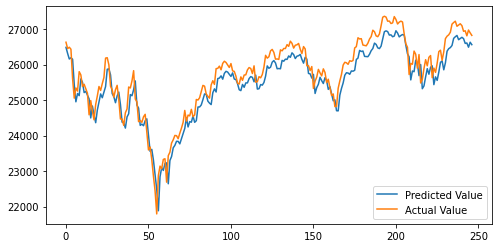

RSME = 357.68084051149816
MAPE = 1.2268345058782115
MAE = 315.43425009159836


In [14]:
#final forecast values
plt.figure(figsize=(8, 4))
plt.plot(y_pred_close, label = 'Predicted Value')
plt.plot(y_test_close, label = 'Actual Value')
plt.legend()
plt.show()
MAE = np.mean(np.abs(y_test_close - y_pred_close))
RMSE = np.sqrt(np.mean(np.square(y_test_close - y_pred_close)))
MAPE = np.mean(np.abs((y_test_close - y_pred_close) / y_test_close)) * 100
print("RSME = " + str(RMSE))
print("MAPE = " + str(MAPE))
print("MAE = " + str(MAE))

### N-BEATS Model

In [15]:
#splitting the data in train, test and validation set after creating windows
seq_len = 20  
x_train, y_train, y_train_dates, x_valid, y_valid, y_valid_dates, x_test, y_test, y_test_dates = load_data(df_norm, 'Close', dates, seq_len, 5, 5)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

247 247
4947
x_train.shape =  (4453, 19)
y_train.shape =  (4453,)
x_valid.shape =  (247, 19)
y_valid.shape =  (247,)
x_test.shape =  (247, 19)
y_test.shape =  (247,)


In [16]:
#Training the model
time_steps, input_dim, output_dim = 19, 1, 1
model = NBeatsNet(backcast_length=time_steps, forecast_length=output_dim,
                  stack_types=( NBeatsNet.TREND_BLOCK, NBeatsNet.SEASONALITY_BLOCK, NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK), nb_blocks_per_stack=4,
                  thetas_dim=(8, 8, 8, 8), share_weights_in_stack=True, hidden_layer_units=128)

model.compile_model(loss = 'mse', learning_rate=1e-5, metrics =['mse','mape','mae'])
model.fit(x=x_train,y=y_train, batch_size=10, epochs = 100,validation_data=(x_valid,y_valid), shuffle=True)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_variable (InputLayer)     [(None, 19, 1)]      0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 19)           0           input_variable[0][0]             
__________________________________________________________________________________________________
0/0/trend/d1 (Dense)            (None, 128)          2560        lambda[0][0]                     
                                                                 subtract[0][0]                   
                                                                 subtract_1[0][0]                 
                                                                 subtract_2[0][0]      

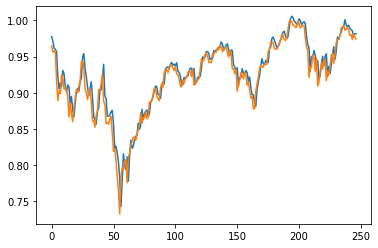

RSME = 0.014190767441776128
MSE = 0.0002013778805865734
MAE = 0.010121304851889334


In [17]:
#forecasting using the trained model
y_pred = model.predict(x_test)
y_pred_close = y_pred[:,-1].reshape(-1)
y_test_close = y_test
plt.plot(y_pred_close)
plt.plot(y_test_close)
plt.show()
MAE = np.mean(np.abs(y_test_close - y_pred_close))
RMSE = np.sqrt(np.mean(np.square(y_test_close - y_pred_close)))
MSE = np.mean(np.square(y_test_close - y_pred_close))
print("RSME = " + str(RMSE))
print("MSE = " + str(MSE))
print("MAE = " + str(MAE))

In [18]:
#rescaling the values
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(df['Close'].values.reshape(-1,1))
data_min = scaler.data_min_[0]
data_range = scaler.data_range_[0]
y_pred_close = (y_pred_close*data_range)+data_min
y_test_close = (y_test_close*data_range)+data_min

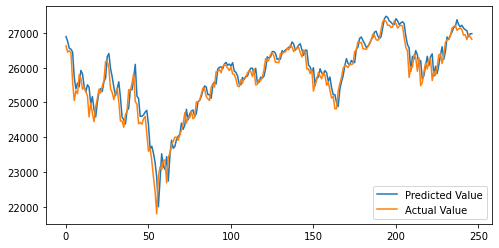

RSME = 295.3394612315757
MAPE = 0.8363058857867036
MAE = 210.6454485151825


In [19]:
#final forecast values
plt.figure(figsize=(8, 4))
plt.plot(y_pred_close, label = 'Predicted Value')
plt.plot(y_test_close, label = 'Actual Value')
plt.legend()
plt.show()
MAE = np.mean(np.abs(y_test_close - y_pred_close))
RMSE = np.sqrt(np.mean(np.square(y_test_close - y_pred_close)))
MAPE = np.mean(np.abs((y_test_close - y_pred_close) / y_test_close)) * 100
print("RSME = " + str(RMSE))
print("MAPE = " + str(MAPE))
print("MAE = " + str(MAE))